## Preamble

In [1]:
import os
import numpy as np
#from scipy import signal
import matplotlib.pyplot as plt

In [5]:
def read(filename,n=(nx,nz)):
    return np.fromfile(filename,dtype='float32').reshape(n).T

def read_su(filename,n=(nr,nt)):
    data=read(filename,n=(n[0],int(60+n[1])))
    return data[60:,:]

def read_snap(filename,n=(nsnap,nxsnap,nzsnap),i=17):
    tmp=np.fromfile(filename,dtype='float32').reshape(n).T
    return tmp[24:24+nz,24:24+nx,i]

def imshow(data,perc=None,clip=None,clipmin=None,extent=None,cmap='viridis',title=None,grid=True):
    
    if perc==None:
        clipp=[np.amin(data),np.amax(data)]
    else:
        tmp=np.percentile(np.abs(data),q=perc)
        clipp=[-tmp,tmp]
    
    if clip!=None: clipp=clip
    
    if clipmin!=None: clipp[0]=clipmin
    
    plt.imshow(data,vmin=clipp[0],vmax=clipp[1],extent=extent,cmap=cmap,aspect='auto')
    plt.colorbar(location='right')
    plt.grid(visible=grid, axis='both', which='both', color='w', linestyle='--',linewidth=0.5)
    #plt.xlabel(labels[0]); plt.ylabel(labels[1])
    if title!=None: plt.title(title)

def run(app='../../exe/FWI',setup='setup',np=1,nthreads=8,out=None):
    '''
    run(app,setup,np=1,nthreads=8)
    run in a bash env
    ----------------------------
    app      : application/executable to run
    setup    : setup file
    np       : number of MPI processors (default=1)
    nthreads : number of OpenMP threads (default=8)
    
    Caveat: np*nthreads should not exceed total number of CPU cores
    otherwise the running will be very slow
    '''
    
    !echo 'ulimit -s unlimited' > run.sh
    str=f"export OMP_NUM_THREADS={nthreads}"
    !echo $str >> run.sh
    str=f"{app} {setup}"
    !echo $str >> run.sh
    !chmod +x run.sh
    if out==None:
        !./run.sh
    else:
        !./run.sh > {out}

In [5]:
#case (11); self%rcv(i)%comp='p'  !pressure

#case (12); self%rcv(i)%comp='vz' !vertical velocity
#case (14); self%rcv(i)%comp='vx' !horizontal velocity in in-line
#case (13); self%rcv(i)%comp='vy' !horizontal velocity in cross-line

#case (21); self%rcv(i)%comp='ez' !ezz
#case (22); self%rcv(i)%comp='ex' !exx
#case (23); self%rcv(i)%comp='ey' !eyy
#case (24); self%rcv(i)%comp='es' !ezx

#case (32); self%rcv(i)%comp='pz' !vertical momenta
#case (34); self%rcv(i)%comp='px' !in-line momenta
#case (33); self%rcv(i)%comp='py' !cross-line momenta

In [34]:
#!lda = rho(vp^2-2vs^2)
#!mu  = rho*vs^2
#!rho0= rho
#!gvp = glda*2rho*vp
#!gvs = (glda*-2 + gmu)*2rho*vs
#!grho= glda*vp^2 + (-2glda+gmu)*vs^2 + grho0
# vp=init
# vs=vp/np.sqrt(3)
# rho=1000.
# def gvp(glda):     return  glda            *2*rho*vp
# def gvs(glda,gmu): return (glda*(-2) + gmu)*2*rho*vs

In [3]:
!bash recompile.sh

rm *.o

rm ../../mod/m_model.mod ../../mod/m_shotlist_batching.mod ../../mod/m_shot.mod ../../mod/m_computebox.mod ../../mod/m_field.mod ../../mod/m_correlate.mod ../../mod/m_cpml.mod ../../mod/m_propagator_PSV_FDSG_O4.mod ../../mod/m_Modeling.mod ../../mod/m_shotlist.mod ../../mod/m_cpml.mod ../../mod/m_propagator.mod ../../mod/m_modeling.mod ../../mod/m_propagator_WPI.mod
rm: cannot remove '../../mod/m_shotlist_batching.mod': No such file or directory
rm: cannot remove '../../mod/m_propagator_PSV_FDSG_O4.mod': No such file or directory
rm: cannot remove '../../mod/m_Modeling.mod': No such file or directory
rm: cannot remove '../../mod/m_cpml.mod': No such file or directory
rm: cannot remove '../../mod/m_propagator_WPI.mod': No such file or directory
make: [Makefile:24: clean] Error 1 (ignored)

(cd FWD; make)
make[1]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/FWD'
#System
(cd ../Modules/System; make)
make[2]: Entering directory '/home/wzhou/Codes/GitHub/SeisJIMU/Modules/S


mpif90 -cpp -Dgfortran -D"git_commit='9edef63'" -D"git_branch='DAS_FS'" -Ofast -fopenmp -ffree-line-length-none -fbacktrace  -fno-unsafe-math-optimizations -frounding-math -fsignaling-nans -J ../../mod/ -c m_correlate.f90 -o m_correlate.o

mpif90 -cpp -Dgfortran -D"git_commit='9edef63'" -D"git_branch='DAS_FS'" -Ofast -fopenmp -ffree-line-length-none -fbacktrace  -fno-unsafe-math-optimizations -frounding-math -fsignaling-nans -J ../../mod/ -c m_cpml.f90 -o m_cpml.o

mpif90 -cpp -Dgfortran -D"git_commit='9edef63'" -D"git_branch='DAS_FS'" -Ofast -fopenmp -ffree-line-length-none -fbacktrace  -fno-unsafe-math-optimizations -frounding-math -fsignaling-nans -J ../../mod/ -c m_propagator_DAS_FDSG_O4.f90 -o m_propagator_DAS_FDSG_O4.o

mpif90 -cpp -Dgfortran -D"git_commit='9edef63'" -D"git_branch='DAS_FS'" -Ofast -fopenmp -ffree-line-length-none -fbacktrace  -fno-unsafe-math-optimizations -frounding-math -fsignaling-nans -J ../../mod/ -c m_Modeling.f90 -o m_Modeling.o


make[2]: Leaving directo

## Numeric test by Robertsson, Fig 1,2, vx force

In [4]:
vp=3000
vs=1730
rho=2500

nz=241; nx=241; h=5
nzsnap=289; nxsnap=289; nsnap=51

fpeak=15

dt=0.0004
nt=2500
t=np.arange(0,nt*dt,dt)-0.067

nr=1

In [6]:
!makevel nx=$nx nz=$nz v000=$vp > vp
!makevel nx=$nx nz=$nz v000=$vs > vs
!makevel nx=$nx nz=$nz v000=$rho> rho
!cat vp vs rho > model

In [7]:
!cat setup_default2

MODEL_SIZE              '241   241   1'
MODEL_SPACING           '5     5     1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        'vp vs rho'

ACQUI_GEOMETRY          spread
FS                      ' 0   100 0'
FR                      '30  1100 0'
DR                      ' 0     0 0'
NR                       1

SCOMP                    vx
RCOMP                   'vz vx p'

NT           2500
DT           0.0004
WAVELET_TYPE ricker
FPEAK        15

SNAPSHOT     'vz vx szz sxx szx'

IF_USE_CHECKPOINT   F


#why the vz comp of dsyn is weird?


### VS modeling + Zero Stress

In [15]:
!cp setup_default2 setup
!echo "SCOMP        vx" >> setup
!echo "FS_METHOD    zero_stress" >> setup
!echo "DIR_OUT      res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 653280 Mar 21 11:13 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 0889ac3
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/21/2024
System time: 11:14:02
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

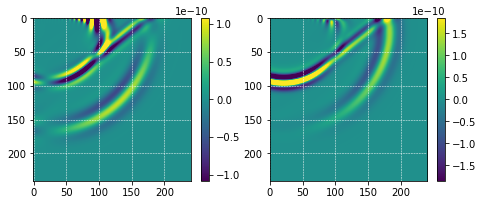

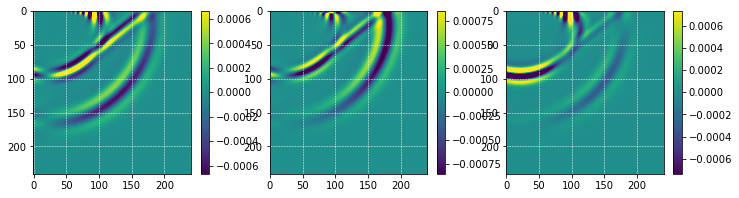

In [16]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'),perc=98)

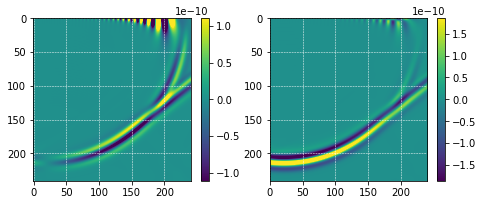

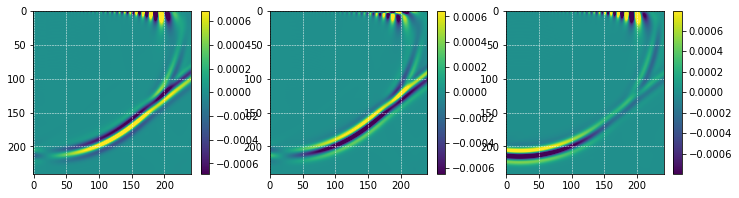

In [17]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=34),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=34),perc=98)

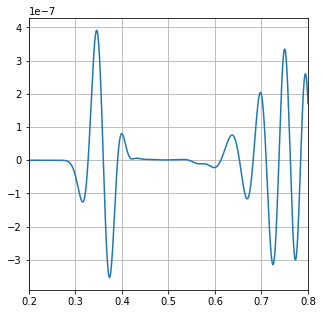

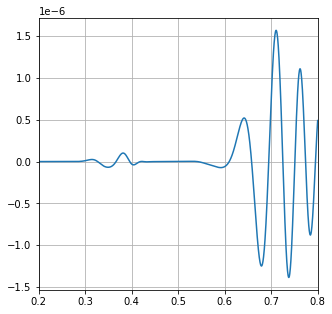

In [18]:
trs=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))*rho

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,1]); plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,0]); plt.xlim([0.2,0.8]); plt.grid()

Strong dispersion!

### VS modeling + Stress Image

In [8]:
!cp setup_default2 setup
!echo "SCOMP        vx" >> setup
!echo "DIR_OUT     res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 653168 Mar 21 10:23 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: a6174f1
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/21/2024
System time: 10:34:29
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

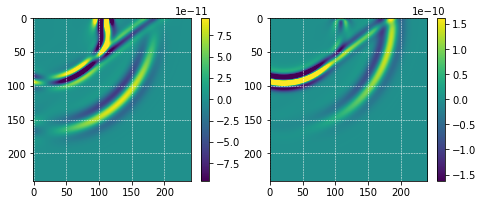

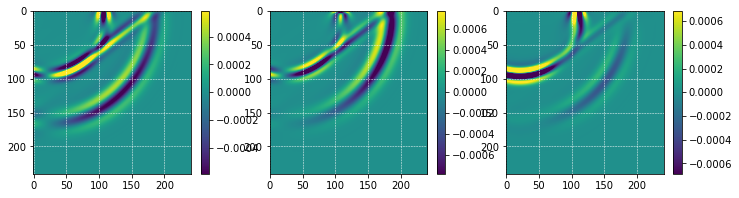

In [9]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'),perc=98)

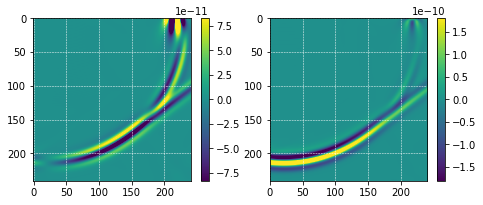

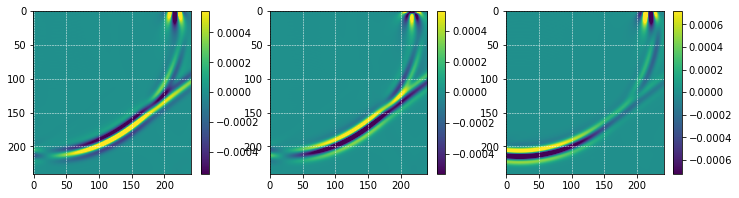

In [33]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=34),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=34),perc=98)

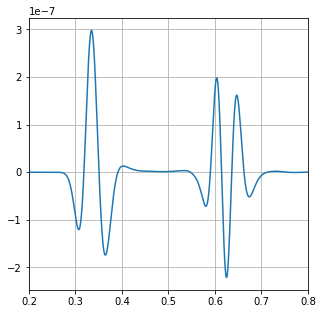

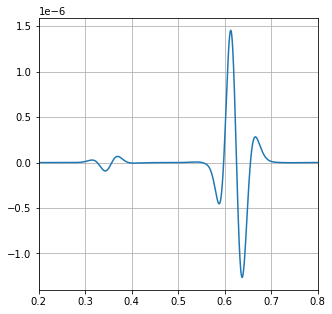

In [10]:
trs=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))*rho

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,1]); plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,0]); plt.xlim([0.2,0.8]); plt.grid()

Robertsson's Figs 1,2. **Well match!**

### VS modeling + Effective medium [not yet working]

In [48]:
!cp setup_default2 setup
!echo "SCOMP        vx" >> setup
!echo "FS_METHOD    'effective_medium'" >> setup
!echo "DIR_OUT     res_VS_eff" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 640520 Mar 10 18:45 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 407c716
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/10/2024
System time: 18:45:14
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS_eff
 Output directory:res_VS_eff/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   ->

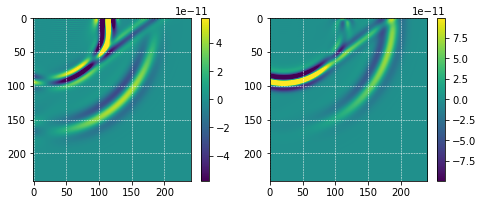

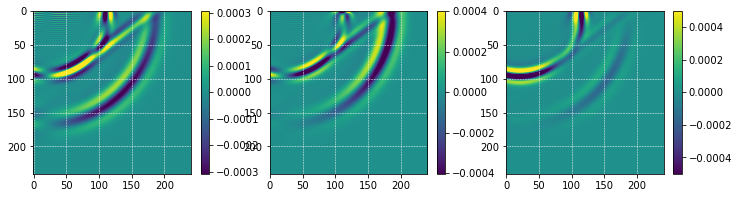

In [49]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS_eff/snap_fld_u%vz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS_eff/snap_fld_u%vx'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS_eff/snap_fld_u%szz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS_eff/snap_fld_u%sxx'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS_eff/snap_fld_u%szx'),perc=98)

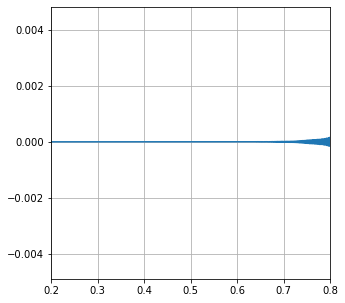

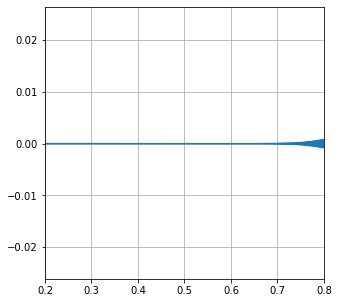

In [39]:
trs=read_su('res_VS_eff/Ru_Shot0001.su',n=(3,nt))*rho

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,1]); plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,0]); plt.xlim([0.2,0.8]); plt.grid()

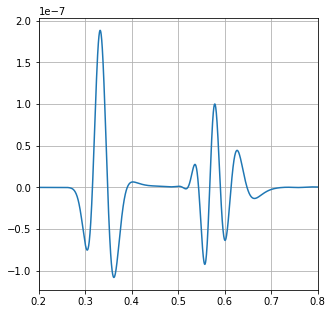

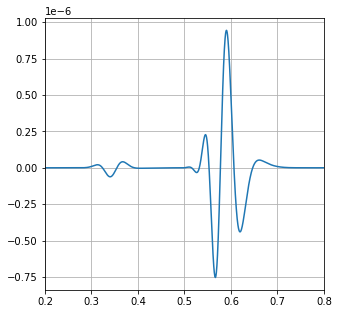

In [94]:
trs=read_su('res_VS_eff/Ru_Shot0001.su',n=(3,nt))*rho

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,1]); plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,0]); plt.xlim([0.2,0.8]); plt.grid()

Doesn't match, even by 2nd-ord FD

### PE modeling + Stress Image

In [76]:
!cp setup_default2 setup

# !echo "IS_FREESURFACE  F" >> setup

!echo "SCOMP        px" >> setup
!echo "RCOMP       'pz px'" >> setup
!echo "SNAPSHOT    'pz px ez ex es'" >> setup
!echo "DIR_OUT     res_PE" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 662904 Mar 12 11:59 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: ea44d45
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/12/2024
System time: 12:57:29
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_PE
 Output directory:res_PE/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

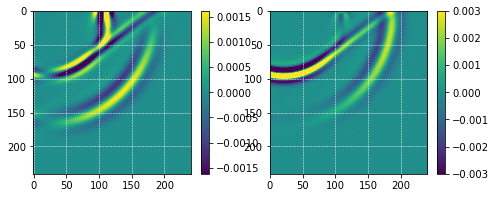

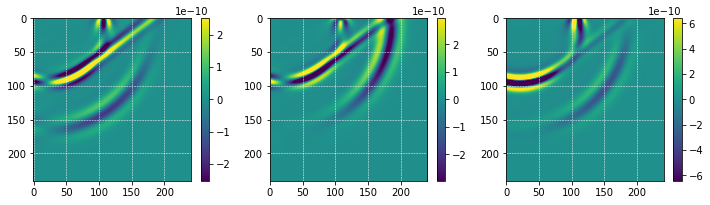

In [36]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%pz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%px'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%ez'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%ex'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_PE/snap_fld_u%es'),perc=98)

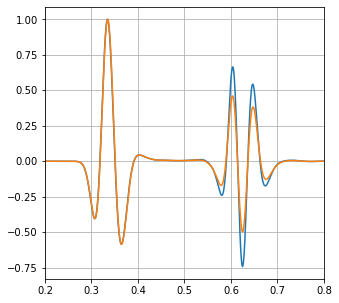

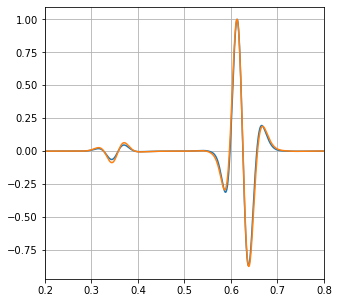

In [37]:
plt.figure(figsize=(5,5))
tr=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))[:,1] ; plt.plot(t,tr/np.amax(tr))
tr=read_su('res_PE/Ru_Shot0001.su',n=(2,nt))[:,1] ; plt.plot(t,tr/np.amax(tr))
plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
tr=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))[:,0] ; plt.plot(t,tr/np.amax(tr))
tr=read_su('res_PE/Ru_Shot0001.su',n=(2,nt))[:,0] ; plt.plot(t,tr/np.amax(tr))
plt.xlim([0.2,0.8]); plt.grid()

- blue (vx & vz) from VS, which is more accurate
- orange (px & pz) from PE

- blue vx is matched for P direct, less matched for S direct
- blue vz is matched

## Numeric test by Robertsson, Fig 1,2, vz force

In [8]:
vp=3000
vs=1730
rho=2500

nz=241; nx=241; h=5
nzsnap=289; nxsnap=289; nsnap=51

fpeak=15

dt=0.0004
nt=2500
t=np.arange(0,nt*dt,dt)-0.067

nr=1

In [9]:
!makevel nx=$nx nz=$nz v000=$vp > vp
!makevel nx=$nx nz=$nz v000=$vs > vs
!makevel nx=$nx nz=$nz v000=$rho> rho
!cat vp vs rho > model

In [10]:
!cat setup_default2

MODEL_SIZE              '241   241   1'
MODEL_SPACING           '5     5     1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        'vp vs rho'

ACQUI_GEOMETRY          spread
FS                      ' 0   100 0'
FR                      '30  1100 0'
DR                      ' 0     0 0'
NR                       1

SCOMP                    vx
RCOMP                   'vz vx p'

NT           2500
DT           0.0004
WAVELET_TYPE ricker
FPEAK        15

SNAPSHOT     'vz vx szz sxx szx'

IF_USE_CHECKPOINT   F


#why the vz comp of dsyn is weird?


### VS modeling + Stress Image

In [11]:
!cp setup_default2 setup
!echo "SCOMP        vz" >> setup
!echo "DIR_OUT     res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 640688 Mar 16 09:49 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: a6174f1
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/16/2024
System time: 09:50:42
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

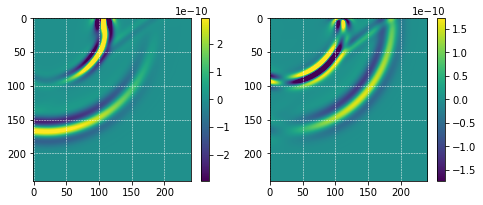

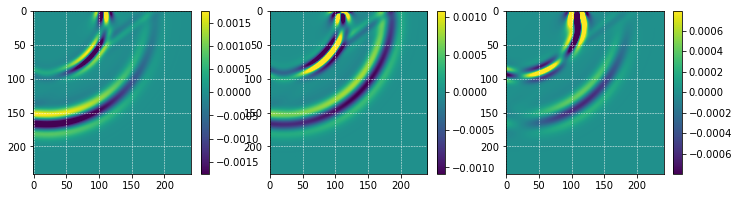

In [12]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'),perc=98)

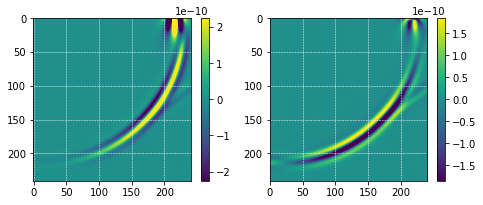

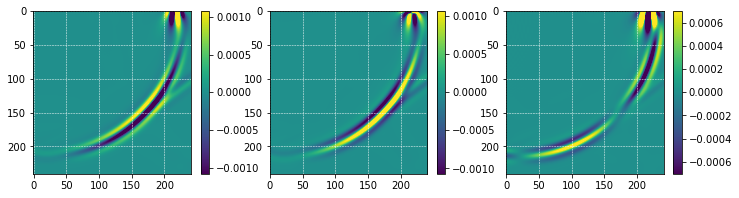

In [13]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=34),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=34),perc=98)

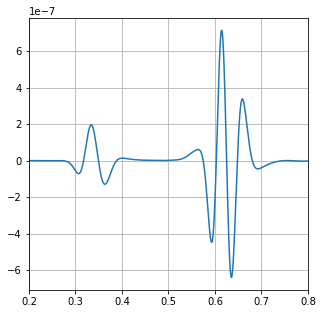

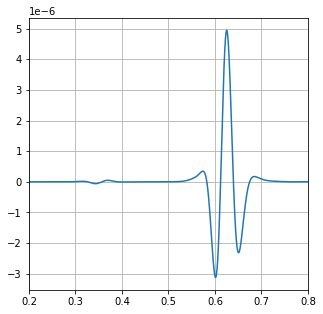

In [14]:
trs=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))*rho

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,1]); plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,0]); plt.xlim([0.2,0.8]); plt.grid()

### PE modeling + Stress Image

In [15]:
!cp setup_default2 setup

# !echo "IS_FREESURFACE  F" >> setup

!echo "SCOMP        pz" >> setup
!echo "RCOMP       'pz px'" >> setup
!echo "SNAPSHOT    'pz px ez ex es'" >> setup
!echo "DIR_OUT     res_PE" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 667232 Mar 16 09:49 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: a6174f1
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/16/2024
System time: 09:51:22
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_PE
 Output directory:res_PE/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

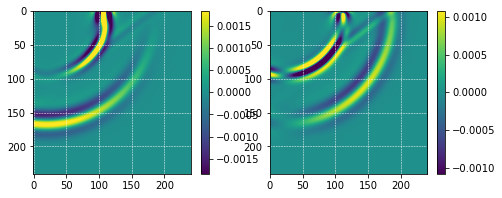

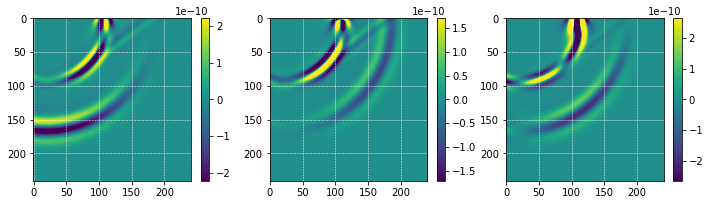

In [16]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%pz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%px'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%ez'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%ex'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_PE/snap_fld_u%es'),perc=98)

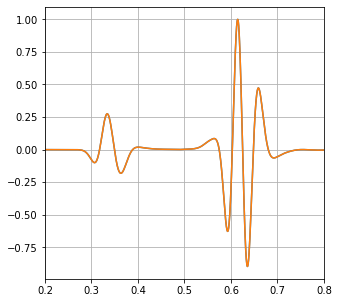

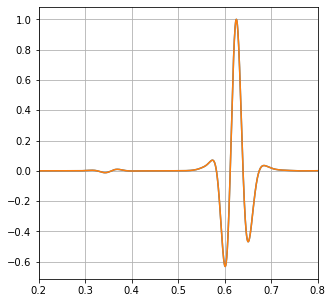

In [17]:
plt.figure(figsize=(5,5))
tr=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))[:,1] ; plt.plot(t,tr/np.amax(tr))
tr=read_su('res_PE/Ru_Shot0001.su',n=(2,nt))[:,1] ; plt.plot(t,tr/np.amax(tr))
plt.xlim([0.2,0.8]); plt.grid()

plt.figure(figsize=(5,5))
tr=read_su('res_VS/Ru_Shot0001.su',n=(3,nt))[:,0] ; plt.plot(t,tr/np.amax(tr))
tr=read_su('res_PE/Ru_Shot0001.su',n=(2,nt))[:,0] ; plt.plot(t,tr/np.amax(tr))
plt.xlim([0.2,0.8]); plt.grid()

Good match!

## Numeric test by Robertsson, Fig 3,4

In [38]:
vp=3000
vs=2121  #Poisson ratio=0
rho=2500

nz=241; nx=241; h=5
nzsnap=289; nxsnap=289; nsnap=51

fpeak=15

dt=0.0004
nt=2500
t=np.arange(0,nt*dt,dt)

In [39]:
!makevel nx=$nx nz=$nz v000=$vp > vp
!makevel nx=$nx nz=$nz v000=$vs > vs
!makevel nx=$nx nz=$nz v000=$rho> rho
!cat vp vs rho > model

In [40]:
!cat setup_default2

MODEL_SIZE              '241   241   1'
MODEL_SPACING           '5     5     1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        'vp vs rho'

ACQUI_GEOMETRY          spread
FS                      ' 0   100 0'
FR                      '30  1100 0'
DR                      ' 0     0 0'
NR                       1

SCOMP                    vx
RCOMP                   'vz vx p'

NT           2500
DT           0.0004
WAVELET_TYPE ricker
FPEAK        15

SNAPSHOT     'vz vx szz sxx szx'

IF_USE_CHECKPOINT   F


#why the vz comp of dsyn is weird?


### VS modeling + Stress Image

In [42]:
!cp setup_default2 setup
!echo "FR          '50  1100 0'" >> setup
!echo "DR          '100    0 0'" >> setup
!echo "NR                    5"  >> setup

!echo "SCOMP        vx" >> setup
!echo "DIR_OUT     res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 640464 Mar 12 12:00 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 2a0a01d
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/12/2024
System time: 12:02:23
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

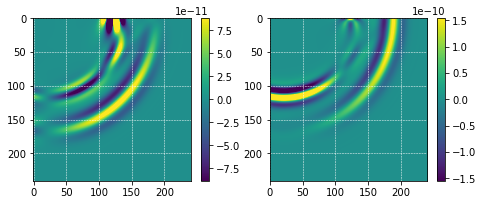

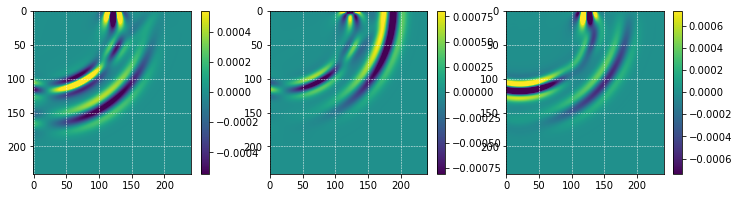

In [43]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'),perc=98)

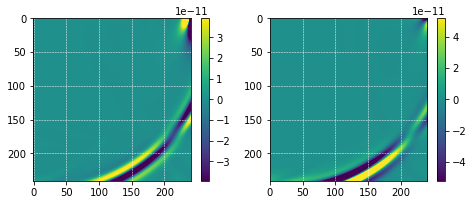

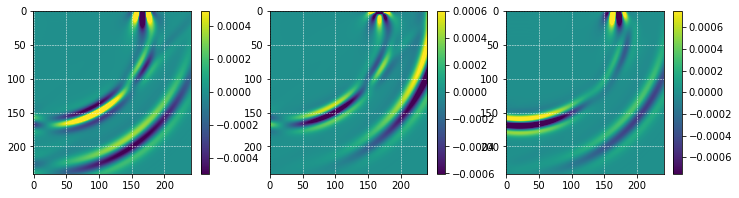

In [44]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=23),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=23),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=23),perc=98)

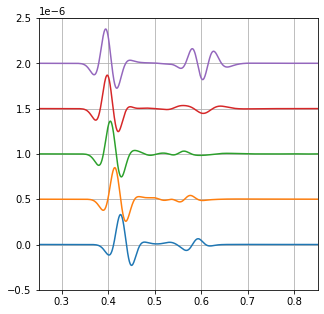

In [45]:
trs=read_su('res_VS/Ru_Shot0001.su',n=(15,nt))[:,5:10]*rho  #vx

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,4]     )
plt.plot(t,trs[:,3]+5e-7)
plt.plot(t,trs[:,2]+10e-7)
plt.plot(t,trs[:,1]+15e-7)
plt.plot(t,trs[:,0]+20e-7)
plt.xlim([0.25,0.85]); plt.ylim([-0.5e-6,2.5e-6]); plt.grid()

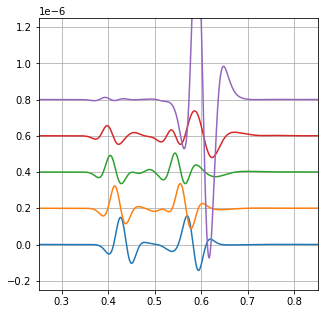

In [46]:
trs=read_su('res_VS/Ru_Shot0001.su',n=(15,nt))[:,0:5]*rho  #vz

plt.figure(figsize=(5,5))
plt.plot(t,trs[:,4]     )
plt.plot(t,trs[:,3]+2e-7)
plt.plot(t,trs[:,2]+4e-7)
plt.plot(t,trs[:,1]+6e-7)
plt.plot(t,trs[:,0]+8e-7)
plt.xlim([0.25,0.85]); plt.ylim([-0.25e-6,1.25e-6]); plt.grid()

Robertsson's Figs 3,4. **Well done!**

### PE modeling + Stress Image

In [49]:
!cp setup_default2 setup

# !echo "IS_FREESURFACE  F" >> setup

!cp setup_default2 setup
!echo "FR          '50  1100 0'" >> setup
!echo "DR          '100    0 0'" >> setup
!echo "NR                    5"  >> setup

!echo "SCOMP        px" >> setup
!echo "RCOMP       'pz px ez'" >> setup
!echo "SNAPSHOT    'pz px ez ex es'" >> setup
!echo "DIR_OUT      res_PE" >> setup
run(app='../../exe/fwd_DAS_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 662904 Mar 12 11:59 ../../exe/fwd_DAS_FDSG_O4_
 Git Commit: ea44d45
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/12/2024
System time: 12:05:26
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_PE
 Output directory:res_PE/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Momemtum-Strain formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

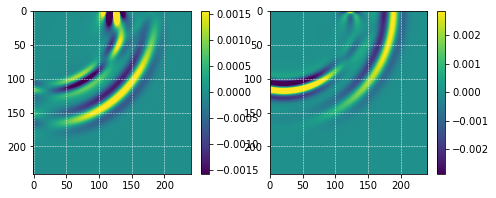

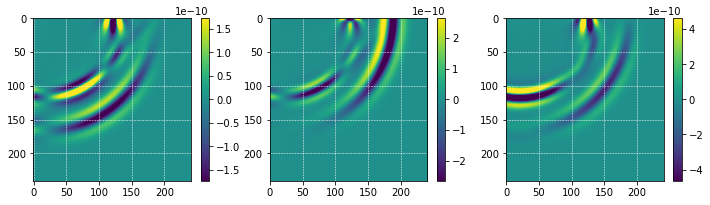

In [48]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%pz'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%px'),perc=98)

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_PE/snap_fld_u%ez'),perc=98)
plt.subplot(1,3,2); imshow(read_snap('res_PE/snap_fld_u%ex'),perc=98)
plt.subplot(1,3,3); imshow(read_snap('res_PE/snap_fld_u%es'),perc=98)

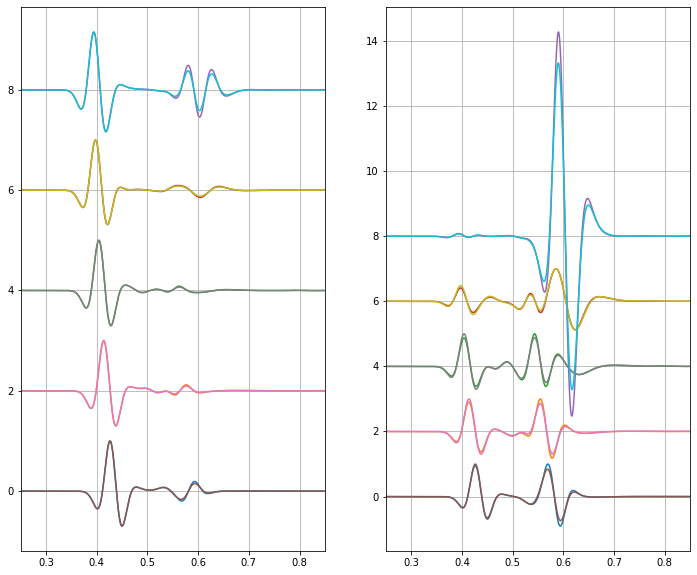

In [56]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
trs=read_su('res_VS/Ru_Shot0001.su',n=(15,nt))[:,5:10] #vx
plt.plot(t,trs[:,4]/np.amax(trs[:,4])  )
plt.plot(t,trs[:,3]/np.amax(trs[:,3])+2)
plt.plot(t,trs[:,2]/np.amax(trs[:,2])+4)
plt.plot(t,trs[:,1]/np.amax(trs[:,1])+6)
plt.plot(t,trs[:,0]/np.amax(trs[:,4])+8)

trs=read_su('res_PE/Ru_Shot0001.su',n=(15,nt))[:,5:10] #px
plt.plot(t,trs[:,4]/np.amax(trs[:,4])  )
plt.plot(t,trs[:,3]/np.amax(trs[:,3])+2)
plt.plot(t,trs[:,2]/np.amax(trs[:,2])+4)
plt.plot(t,trs[:,1]/np.amax(trs[:,1])+6)
plt.plot(t,trs[:,0]/np.amax(trs[:,4])+8)

plt.xlim([0.25,0.85]); plt.grid()


plt.subplot(1,2,2)
trs=read_su('res_VS/Ru_Shot0001.su',n=(15,nt))[:,0:5]  #vz
plt.plot(t,trs[:,4]/np.amax(trs[:,4])  )
plt.plot(t,trs[:,3]/np.amax(trs[:,3])+2)
plt.plot(t,trs[:,2]/np.amax(trs[:,2])+4)
plt.plot(t,trs[:,1]/np.amax(trs[:,1])+6)
plt.plot(t,trs[:,0]/np.amax(trs[:,4])+8)

trs=read_su('res_PE/Ru_Shot0001.su',n=(15,nt))[:,0:5] #pz
plt.plot(t,trs[:,4]/np.amax(trs[:,4])  )
plt.plot(t,trs[:,3]/np.amax(trs[:,3])+2)
plt.plot(t,trs[:,2]/np.amax(trs[:,2])+4)
plt.plot(t,trs[:,1]/np.amax(trs[:,1])+6)
plt.plot(t,trs[:,0]/np.amax(trs[:,4])+8)

plt.xlim([0.25,0.85]); plt.grid()

- vx is matched for P, less matched for S
- vz is matched

## [wait]

## Numeric test by Chen-2021-GEO-FreeSurface, Fig3

In [2]:
vp=3500
nu=0.25;  vs=vp/np.sqrt(3)
rho=2500

nz=401; nx=401; h=4
nzsnap=449; nxsnap=449; nsnap=50

fpeak=15

dt=0.00068
nt=1470
t=np.arange(0,nt*dt,dt)

nr=2

In [8]:
!cat setup_default

MODEL_SIZE              '401   401   1'
MODEL_SPACING           '4     4    1'
MODEL_ORIGIN            '0     0     0'
FILE_MODEL              'model'
MODEL_ATTRIBUTES        'vp vs rho'

ACQUI_GEOMETRY          spread
FS                      '40   200 0'
FR                      ' 0  1400 0'
DR                      ' 2    2  0'
NR                       2

SCOMP                    p
RCOMP                   'vz vx p'

#ntr=6: vz@(0m,1400m),(2m,1402m); vx@(0m,1400m),(2m,1402m); p@(0m,1400m),(2m,1402m)
#we compar itr=2,1

NT           1470
DT           0.00068
WAVELET_TYPE ricker
FPEAK        15
T0           0.16

SNAPSHOT     'vz vx szz sxx'

IF_USE_CHECKPOINT   F


#why the vz comp of dsyn is weird?


In [13]:
!makevel nx=$nx nz=$nz v000=$vp > vp
!makevel nx=$nx nz=$nz v000=$vs > vs
!makevel nx=$nx nz=$nz v000=$rho> rho
!cat vp vs rho > model

### VS modeling SCOMP p

In [25]:
!cp setup_default setup
!echo "FS_method   'stress image'" >> setup

!echo "FS          '400 400  0'" >> setup
!echo "SCOMP        p" >> setup
!echo "DIR_OUT     res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 635528 Mar  8 12:08 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 3c2ff88
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/08/2024
System time: 12:08:47
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

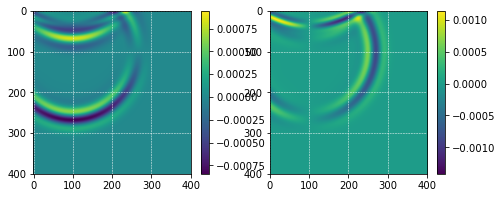

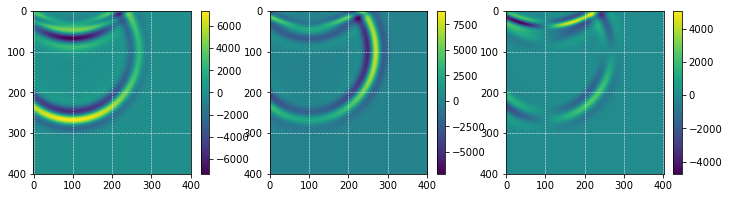

In [26]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'))
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'))

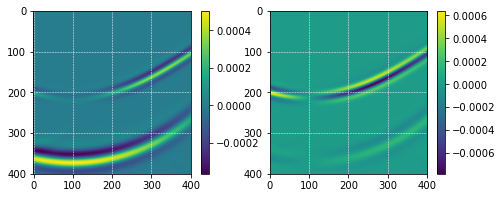

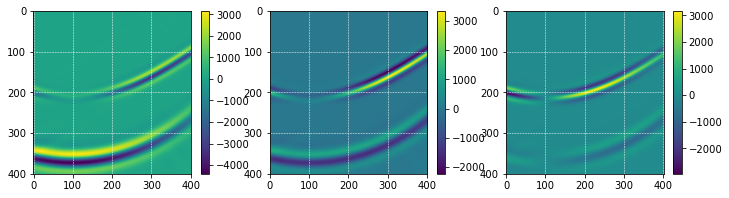

In [27]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=34))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=34))
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=34))

### VS modeling SCOMP vz

In [28]:
!cp setup_default setup
!echo "FS_method   'stress image'" >> setup

!echo "FS          '400 400  0'" >> setup
!echo "SCOMP        vz" >> setup
!echo "DIR_OUT     res_VS" >> setup
run(app='../../exe/fwd_PSV_FDSG_O4_')

 MPIWorld info:
  MPI_INIT_THREAD level:           0
  Number of MPI processors:           1
  Max number of OMP threads / processor:           8
 Working directory: (pwd)
/home/wzhou/Codes/GitHub/SeisJIMU/Demo/01_ForwardModeling_DAS_Freesurface
 Using executable: (ls -l $exe)
-rwxrwxr-x 1 wzhou wzhou 635528 Mar  8 12:08 ../../exe/fwd_PSV_FDSG_O4_
 Git Commit: 3c2ff88
 Git Branch: DAS_FS
 Compiler: gfortran v11.4.0
 Version: 11.4.0
 Endianness:         1234
 System date: 03/08/2024
System time: 12:09:35
System timezone: +03:00
                        
   WELCOME TO SeisJIMU FWD MODELING   
 Setup file: setup
 DIR_IN is NOT found, take default: ./
 Input directory: ./
 DIR_OUT : res_VS
 Output directory:res_VS/
 Invoked field & propagator modules info : 
Time-domain ISOtropic 2D P-SV (ELastic) propagation
1st-order Velocity-Stress formulation
Vireux-Levandar Staggered-Grid Finite-Difference (FDSG) method
Cartesian O(x⁴,t²) stencil
CFL = Σ|coef| *Vmax *dt /rev_cell_diagonal
   -> dt ≤ 0.

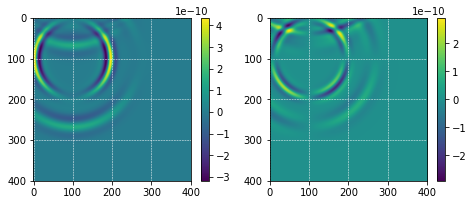

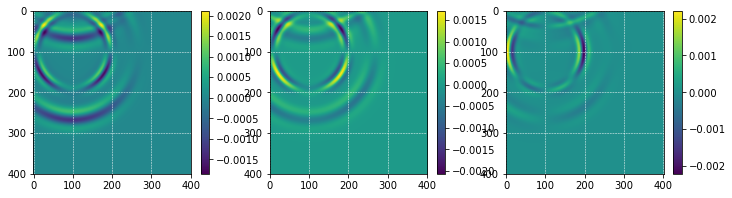

In [30]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz'))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx'))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz'))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx'))
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx'))

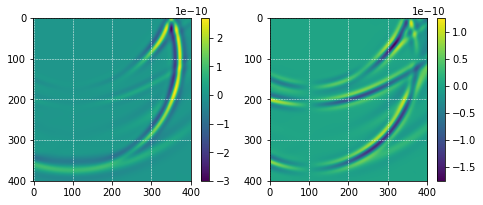

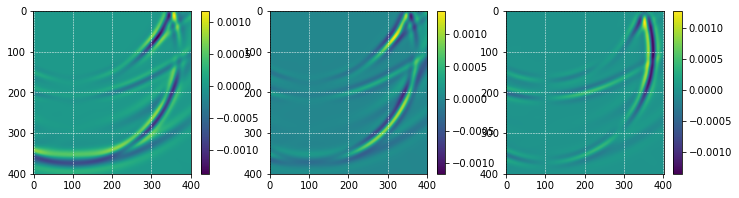

In [31]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%vz',i=34))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%vx',i=34))

plt.figure(figsize=(12,3))
plt.subplot(1,3,1); imshow(read_snap('res_VS/snap_fld_u%szz',i=34))
plt.subplot(1,3,2); imshow(read_snap('res_VS/snap_fld_u%sxx',i=34))
plt.subplot(1,3,3); imshow(read_snap('res_VS/snap_fld_u%szx',i=34))